In [ ]:
# default_exp primitives

In [ ]:
#hide
#For running in JupyterHub:
import os
if os.path.basename(os.getcwd())!='nbs':
    homedir = os.path.expanduser("~")
    lib_path = os.path.join(homedir,'images','codesDIR/vertex_simulation/nbs')
    os.chdir(lib_path)

# Primitives

> Implementations for vertex, graph, and cell monolayer classes

In [ ]:
#hide
from nbdev.showdoc import *

# For running in JupyterHub

# import os
# homedir = os.path.expanduser("~")
# lib_path = os.path.join(homedir,'images','codesDIR/vertex_simulation')
# os.chdir(lib_path)
# !pwd

- Graph primitives:
    - `Vertex`: implements a vertex object. Stores position of a given vertex (or vertices) as `1x2` `torch.tensor`, and implements methods for interacting with `torch` autograd. Compatible with D-dimensional `NxD` `torch.tensor`.
    - `Graph`: implements graph object. Stores vertices (`Vertex` object with `NxD` `torch.tensor`), edges (`Nx2` integer array of vertex indices) connecting the vertices, and implements methods for interacting with `torch` autograd.
- Cell monolayer representations: 
    - `Monolayer`: Implements cell monolayer, such as (2-dimensional) apical plane of an epithelial tissue. Inherits from `Graph` class. [__needs docs__]
        - `Graph` and `Monolayer` have "to", and "device" methods.
- to-do:
    - extend `VoronoiRegions2Edges` to add out-of-diagram vertices as boundary vertices (or partial cells)
    - need to add tranfer to GPU and back

In [ ]:
#export
import torch
import numpy as np, matplotlib.pyplot as plt
from scipy.spatial import Voronoi,voronoi_plot_2d

## Helper functions for Graphs
---

In [ ]:
#export
def plot_graph(Xv,edges,plot_arg=['g-','mo'],alphas=[.2,.5]):
    '''A function for plotting simple graphs (slow for large graphs)
    - `Xv`: vertex locations
    - `edges`: graph edges as indices of the vertex pairs that form.
    Nx2 array of integers (could be list of lists)
    '''
    for ij in edges:
        plt.plot([Xv[ij[0],0], Xv[ij[1],0]], [Xv[ij[0],1], Xv[ij[1],1]],plot_arg[0],lw=2,alpha=alphas[0])
    plt.plot(Xv[:,0],Xv[:,1],plot_arg[-1],ms=10,alpha=alphas[-1])
    plt.axis('equal')
    plt.axis(False);

In [ ]:
#export
def plot_graph_as_quiver(g,quiver_kwargs = {'units':'xy','angles':'xy',
                                            'scale_units':'xy','scale':1.0,
                                            'headwidth':0,'headlength':0,
                                            'width':.05,'color':'g'},return_Q=False):
    '''Plot `Graph` or `Monolayer` object edges.'''
    edge_dirs = g.direction().detach().cpu()
    vx = g.vertices.x.detach().cpu()
    # vertices with edges:
    Q=plt.quiver(vx[g.edges[:,0],0],vx[g.edges[:,0],1],
                 edge_dirs[:,0],edge_dirs[:,1],**quiver_kwargs)
    plt.axis(False);
    if return_Q:
        return Q

In [ ]:
#export
import networkx as nx
def graph2networkx_with_pos(g):
    '''Convert `Graph` or `Monolayer` object toReturn `network` graph '''
    G = nx.Graph(g.edges.tolist())
    pos=dict(zip(range(g.vertices.x.shape[0]),g.vertices.x.detach().cpu().numpy()))
    return G, pos

## Helper functions for Monolayer
---

In [ ]:
#export
def is_in_edges_(e,edge_list):
        '''Returns edge index in the list, "-" means in reversed order, False if not found. 
        Used by `VoronoiRegions2Edges`
        '''
        if (e in edge_list):
            return edge_list.index(e)+1
        elif ((e[1],e[0]) in edge_list):
            return -(1+edge_list.index((e[1],e[0])))
        else:
            return False

Slowest part of `VoronoiRegions2Edges` is checking whether the edge is in the list of edges, `is_in_edges_()` function. In `is_in_edges_` most of the time is spent for the `if, elif` conditionals (using `np` binary indexing in `is_in_edges_` didn't speed up finding regions, actually it slowed it down), need to change how `VoronoiRegions2Edges` works in particular adding edges to list (or need to even avoid it).

In [ ]:
#export
def VoronoiRegions2Edges(regions):
    '''Converts Voronoi region vertex indices, like the one obtained from `scipy.spatial.Voronoi`, 
    to a list of (*undirected*) edges (indices of vertex pairs).
    
    Edges [i,j] and [j,i] are considered to be the same edge, and stored as one of these 
    representations e.g. [j,i], but not both (i.e. no duplicate edges). Note that edge indexing in
    `cells` starts from 1 (not 0!). Thus, when reading cell edges from `edge_list` you need to 
    substract 1 from (absolute value of) these indices.
    
    Usage:
    - `edge_list,cells = VoronoiRegions2Edges(vrn_regions)`
    
    Arg-s:
    - `regions` is a list of lists, empty regions, or regions with out-of-diagram vertices ("-1") are ignored
    
    Returns:
    - `edge_list` : list of edges of an undirected graph.
    - `cells`: dictionary of cells (Voronoi regions), keys: cell numbers, values: list of 
    **edge indices starting from 1**. Negative indices indicate reversed order for vertices 
    (together these edges form a closed region--a cell). Use `np.sign(cells[c])` to find reversed edges.
    '''
    edge_list = []
    cells = {}
    cell_k = 0
    regions = [r for r in regions if not (len(r)==0 or (-1 in r ))]
    for r in regions:
#         if len(r)==0 or (-1 in r ):
#             continue # ignore empty regions or those with vertex index -1
        cells[cell_k] = []
        for e in zip(r[-1:]+r[:-1],r):
            edge_idx = is_in_edges_(e,edge_list)
            if edge_idx:
                cells[cell_k].append(edge_idx)
            else:
                cells[cell_k].append(len(edge_list)+1)
                edge_list.append(e)
        cell_k+=1
    return edge_list,cells

In [ ]:
#hide
# %load_ext line_profiler
# v_x,regions =unit_hexagons(5,7)
# %lprun -f is_in_edges_ VoronoiRegions2Edges(regions)

## Graph primitives

In [ ]:
#export
class Vertex(object):
    '''Implements vertex and stores vertex position(s) as Nx2 (or any 2-D tensor) `torch.Tensor`:(x,y,...)'s.
    Rows represent points, columns the spatial dimensions, i.e. `[[x1,y1], [x2,y2], ...,[xN,yN]]`
    
    - Methods:
        - `dist(self,other)` : calculates Euclidean distance between two points (each row).
        - `zero_grad_(self)` : set all gradients to zero (used during gradient descent at each iter-n step).
        - `grad(self)` : get gradient w.r.t. each tensor in `self.x`
        - `requires_grad_(self,val)`: sets `torch.tensor` flag inplace
        - `requires_grad(self)`: returns `torch.tensor` flag
    - Properties :
        - `x` : use it to set/get location torch.tensor (returns or modifies self.x) [<a name="Vertex.x">Vertex.x</a>]
    '''
    def __init__(self,location=None,**kwargs):
        '''`location` must be a 2D `torch.tensor` w/ float dtype (or a compatible list of lists,
        and numpy.ndarray). Set and get `location` with `self.x` property.
        
        Important note on setting `requires_grad` flag. If the given `location` is a `numpy.ndarray` 
        keyword arg-s are ingnored (uses `torch.from_numpy()`). In such cases, use `self.requires_grad_(True)`
        after the initialization to set the flag inplace.
        
        Usage:
        `v = Vertex(torch.tensor([[3.,-1.]],requires_grad=True,dtype=torch.float64))`
        '''
        if location is not None:
            if type(location) is list:
                location = torch.tensor(location,**kwargs)
            elif type(location) is np.ndarray:
                location = torch.from_numpy(location)
            assert location.ndim==2, f"Input 'location' has wrong dimensions, location.ndim!=2 :'( "
        self._x=location
    
    def dist(self,other):
        ''' Calculate (Euclidean) distance to another vertex from self._x.'''
        return torch.norm(other.x - self._x,dim=1,p=2,keepdim=True)
    
    def zero_grad_(self):
        '''set gradients to zero if x.requires_grad==True'''
        if self._x.grad is not None:
            self._x.grad.data.zero_()
    
    def grad(self):
        '''Get accumulated gradients w.r.t. x (calculated with backprop; `torch.autograd`)'''
        return self._x.grad
    
    def requires_grad_(self,val):
        '''Access to `torch.tensor` method to change `requires_grad` status'''
        self._x.requires_grad_(val)
        
    def requires_grad(self):
        '''Access to `torch.tensor` method to view `requires_grad` status'''
        return self._x.requires_grad
    
    def device(self):
        """Returns torch tensor's device"""
        return self.x.device
    def to_(self,val):
        """Change torch tensor's device"""
        self._x = self.x.detach().to(val).requires_grad_(self.requires_grad())
    
    def dtype(self):
        """Returns torch tensor's dtype"""
        return self.x.dtype
    
    @property
    def x(self):
        return self._x
    @x.setter
    def x(self, val):
        self._x = val
    
    def __str__(self):
        return f"{self._x}"
    def __repr__(self):
        return f"Vertex {self._x}; dtype:{self._x.dtype}"
    

---
Define vertices with Nx2 (or NxD in general, N:number of vertices, D: number of spatial dimesions) torch tensors:

In [ ]:
# initialise and then set vertex location 
o=Vertex()
o.x=torch.tensor([0.,0.], dtype=torch.float32)

# or with location at init-n
v1=Vertex([[1.,1.]],dtype=torch.float32)

# you can transfer "v1" and "o" to GPU
print(f'v1: {v1.device()}\n',f'o : {o.device()}')
if torch.cuda.device_count():
    v1.to_('cuda')
    o.to_(v1.device())
print(f'CUDA devices found: {torch.cuda.device_count()}\n',
      f'v1: {v1.device()}\n',f'o : {o.device()}')

# calculate distance between vertices
r = o.dist(v1)
print(f"Distance between two vertices (o <--> v1) : {r.squeeze()}")

v1: cpu
 o : cpu
CUDA devices found: 1
 v1: cuda:0
 o : cuda:0
Distance between two vertices (o <--> v1) : 1.4142135381698608


---

In [ ]:
#export
class Graph(object):
    '''Implements graph object. Stores vertices and edges. 
    - Methods:
        - `length(self)` : calculates (Euclidean) edge lengths for each edge in the graph.
        - `direction(self)`: calculates edge vectors (`second_vertex - first_vertex` positions)
        - `get_vertex_grad(self)`: returns accumulated gradients w.r.t. to vertex positions.
        - `set_zero_grad_(self)`: sets gradients w.r.t. to vertex positions to zeros.
    - Properties :
        - `vertices` : variable vertices represented by `Vertex` object (needs autograd).
        - `edges` : edges connecting vertices.Nx2 array of integers (vertex indices).
        Can be any `torch.tensor` compatible array with `tolist()` method (doesn't need autograd).
        - `fixed`: [__not yet implemented__] stores information about constant/fixed vertices (for setting boundary).
        Provided for convenience, turn off gradient calculation separately from "variable" vertices to keep them constant.
        '''
    def __init__(self,vertices=None, edges=None, fixed=None):
        '''Init-n function for `Graph` objects. Stores vertices and edges.
        
        Usage:
            `g = Graph(edges=torch.tensor([[0,1],[1,2],[2,0]]), vertices=Vertex(torch.tensor([[1,1],[0,-1],[-1,0]]))`
        ''' 
        self._vertices = vertices
        self._edges = edges
        self._fixed= fixed
    
    def length(self):
        ''' Calculates all edge lengths in the graph.
        Lengths--(Euclidean) distances between vertex pairs connected with edges.
        Order of the lengths is same as the order of the edges, i.e. i'th result corresponds to i'th edge.
        '''
        return torch.norm(self.vertices.x[self.edges[:,1],:] - self.vertices.x[self.edges[:,0],:],
                          dim=1,p=2,keepdim=True)
        
    def direction(self):
        '''Calculates edge vector (direction) from first vertex to its pair connected with an edge.'''
        return self.vertices.x[self.edges[:,1],:] - self.vertices.x[self.edges[:,0],:]
    
    def get_vertex_grad(self):
        '''Get accumulated gradients w.r.t. vertex positions (`self.vertices.x`) (calculated with backprop; `torch.autograd`)'''
        return self.vertices.grad()
    
    def set_zero_grad_(self):
        '''Set gradients to zero if `requires_grad` is set to `True` for variable vertices. Uses `vertices.zero_grad_()`'''
        self.vertices.zero_grad_()
        
    def device(self):
        '''Return Vertex and Edge tensor devices as dict.'''
        return {'vertices':self.vertices.device(), 'edges':self.edges.device}
    def to_(self,val):
        '''Set Vertex and Edge (vertes IDs) devices to "val"'''
        self.vertices.to_(val)
        self.edges = self.edges.to(val)
        
    @property
    def edges(self):
        return self._edges
    @edges.setter
    def edges(self,val):
        self._edges = val
    
    @property
    def vertices(self):
        return self._vertices
    @vertices.setter
    def vertices(self, val):
        self._vertices = val
    
    @property
    def fixed(self):
        return self._fixed
    @fixed.setter
    def fixed(self, val):
        self._fixed = val
    
    def __str__(self):
        if (self.edges is None) or (self.vertices is None):
            return f"Graph: edges {self._edges}; vertices {self.vertices}"
        dtype_edges = self.edges.dtype
        dtype_verts = self.vertices.dtype()
        return f"Graph\nedges {self._edges} {dtype_edges};\nvertices {self.vertices} {dtype_verts}"
    def __repr__(self):
        n_edges = self.edges if self.edges is None else self.edges.size(0)
        n_verts = self.vertices if self.vertices is None else self.vertices.x.size(0)
        return f"Graph: {n_edges} edges; {n_verts} vertices"
    

---

When initializing `Graph` objects provide vertices (as `Vertex` object) and edges (connected vertex indices) at initialization, or set it later with `self.vertices` and `self.edges` property setters.

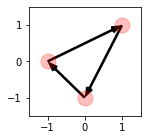

In [ ]:
g = Graph(vertices = Vertex([[1,1],[0,-1],[-1,0]], dtype=torch.float64, requires_grad=True),
          edges = torch.tensor([[0,1],[1,2],[2,0]]) )

# Plot vertex positions
plt.figure(figsize=[2,2])
plt.plot(g.vertices.x.detach()[:,0], g.vertices.x.detach()[:,1],'ro',ms=15,alpha=.25);# this plots all vertices
# plot directed edges to check them, to calculate direction use `direction()` function in Graph object
quiver_kwargs = {'units':'xy','angles':'xy','scale_units':'xy',
                 'scale':1.0,'headwidth':3,'headlength':4,'width':.07}
plot_graph_as_quiver(g,quiver_kwargs=quiver_kwargs) #plot edges with directions
plt.axis([-1.5,1.5,-1.5,1.5]);plt.axis(True)
plt.show()

Use `device()` and `to_()` to check device and move `Graph` tensors (vertices and edges) to GPU

In [ ]:
print(g.device())
if torch.cuda.device_count():
    g.to_('cuda')
    print(g.device())

{'vertices': device(type='cpu'), 'edges': device(type='cpu')}
{'vertices': device(type='cuda', index=0), 'edges': device(type='cuda', index=0)}


Evaluating functions that depend on vertex positions (edge Euclidean length, and direction functions are already implemented in `Graph` class)
- Example below illustrates how to compute spatial gradient $\frac{\partial E}{\partial x_i}$ for $E(\{x_i\})=\sum_{edges}l_{ij}^2$ for vertices shown in the graph above. In a more general case, you can use vertex positions using `g.vertices.x` of a `Vertex` object, and check gradient tag with `g.vertices.requires_grad()` and enable gradient tracking inplace with `g.vertices.requires_grad_(True)`.

In [ ]:
# do something with vertex positions
l = g.length() # edge lengths
E = torch.sum(l**2) # some function that returns a scalar

# compute gradients w.r.t. variables of E 
E.backward()

# copying grad-s into dEdx as a list
dEdx=g.get_vertex_grad().tolist()

# reset gradients to zeros (useful for iterative calculations s.a. gradient descent)
g.set_zero_grad_()
dEdx_2=g.get_vertex_grad().tolist()
print(f'dEdx={dEdx}\n---\nafter zeroing gradients\ndEdx={dEdx_2}')

dEdx=[[6.0, 6.0], [0.0, -6.0], [-6.0, 0.0]]
---
after zeroing gradients
dEdx=[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0]]


## Cell monolayer representations

In [ ]:
#export
class Monolayer(Graph):
    '''Implements 2-dimensional cell monolayer (apical plane) represented by vertices and edges.
    
    `Monolayer` inherits *all methods, and properties* of `Graph`
    
    - Methods:
        - `perimeter(self)` : calculates cell perimeters. Returns `torch.tensor`.
        - `area(self)` : calculates cell areas (2-d polygons). Returns `torch.tensor`.
        [<a name="Monolayer.area">Monolayer.area</a>]
    - Properties:
        - `cells` : dictionary of lists, with cell numbers (keys) and list of 
    **edge indices starting from 1** (values). Negative indices indicate reversed order for vertices 
    (cell is defined as a closed region formed by edges connected end-to-end).
    Use `np.sign(cells[c])` to find reversed edges for cell `c`.
    '''
    def __init__(self, vertices=None, edges=None, cells=None, fixed=None):
        '''Usage:
        - cells = Monolayer(edges=torch.tensor([[0,1],[1,2],[2,0]]), vertices=Vertex([[1.,1.],[0.,-1.],[-1.,0.]]))
        '''
        super().__init__(vertices=vertices, edges=edges, fixed=fixed)
        
        # cells must be a dict (keys:cell#,values:edge indices w/ negative indices for reverced edge direction)
        self._cells = cells 
        
    def perimeter(self):
        '''Calculates perimeters of the cells'''
        if (self.cells is None) or len(self.cells)==0:
            return torch.zeros((1,))
        Perims = []
        for c in self.cells:
            c_edges = self.edges[np.abs(self.cells[c])-1,:]
            Perims.append(torch.sum(torch.norm(
                self.vertices.x[c_edges[:,1],:] - self.vertices.x[c_edges[:,0],:],
                dim=1,p=2,keepdim=True),0,keepdim=True))
        return torch.cat(Perims,dim=0)
    
    def area(self):
        '''Calculates areas of the cells. Defined only for simple 2D polygons ("shoelace formula")'''
        if (self.cells is None) or len(self.cells)==0:
            return torch.zeros((1,))
        Areas = []
        for c in self.cells:
            # compute area of each cell
            c_edges = self.edges[np.abs(self.cells[c])-1,:]
            if np.any(np.sign(self.cells[c])<0):
                # reverse vertex order for negative edges
                tmp = c_edges[np.sign(self.cells[c])<0,:]
                c_edges[np.sign(self.cells[c])<0,0]=tmp[:,1]
                c_edges[np.sign(self.cells[c])<0,1]=tmp[:,0]
            xy = self.vertices.x[c_edges[:,0],:]
            Areas.append(torch.abs( 
                torch.sum(xy[:-1,0]*xy[1:,1],0,keepdim=True) + xy[-1,0]*xy[0,1]
                -torch.sum(xy[1:,0]*xy[:-1,1],0,keepdim=True) - xy[0,0]*xy[-1,1] )/2 )
            
        return torch.cat(Areas,dim=0)
    
    @property
    def cells(self):
        return self._cells
    @cells.setter
    def cells(self, val):
        self._cells = val
    
    def __str__(self):
        n_cells = self.cells if self.cells is None else len(self.cells)
        return f"Monolayer {n_cells} cells\n{self.cells};\n{super().__str__()}"
    def __repr__(self):
        n_cells = self.cells if self.cells is None else len(self.cells)
        return f"Monolayer {n_cells} cells, {super().__repr__()}"

---

* `Monolayer` assumes that cells are 2D *simple polygons*. For a *simple polygon* with $n$ sides, `Monolayer.area` implements a [*shoelace formula*](https://en.wikipedia.org/wiki/Shoelace_formula):
$$A_{polygon} = \frac{1}{2}\left|{\sum^{n-1}_{i=1}x_{i}y_{i+1} + x_ny_1 - \sum^{n-1}_{i=1}x_{i+1}y_{i} - x_1 y_n}\right|$$
$$ = \frac{1}{2}\left|x_1y_2+x_2y_3+\dots+x_{n-1}y_n +x_ny_1 - x_2y_1-x_3y_2-\dots-x_ny_{n-1}-x_1y_n\right|$$

* You can use `Graph` functions `to_()` and `device()` to move tensors to GPU and check tensor's device

m is on : {'vertices': device(type='cpu'), 'edges': device(type='cpu')}
Perimeter= tensor([[3.4142]]) ; Area= tensor([0.5000])


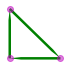

In [ ]:
# triangle shaped cell:
v = Vertex([[-.5,-.1],[-.5,.9],[.5,-.1]])
edges = torch.tensor([[0,1],[1,2],[2,0]])
tri_cells = {0:[1,2,3]}
m = Monolayer(vertices=v,edges=edges,cells=tri_cells)
print('m is on :', m.device())
print('Perimeter=',m.perimeter(),'; Area=',m.area())

# plot monolayer graph
plt.figure(figsize=[1,1])
plot_graph_as_quiver(m)
plt.plot(m.vertices.x[:,0],m.vertices.x[:,1],'mo',alpha=.5);

Note that we need to remember to copy tensors to CPU (and detach from the Pytorch's computational graph) to be able to use `matplotlib`

m is on : {'vertices': device(type='cuda', index=0), 'edges': device(type='cuda', index=0)}
Perimeter= tensor([[3.4142]], device='cuda:0') ; Area= tensor([0.5000], device='cuda:0')


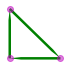

In [ ]:
# Now let's do the same computation on GPU (if available)
if torch.cuda.device_count():
    m.to_('cuda')
    print('m is on :', m.device())
    print('Perimeter=',m.perimeter(),'; Area=',m.area())

    # plot monolayer graph
    plt.figure(figsize=[1,1])
    plot_graph_as_quiver(m)
    plt.plot(m.vertices.x[:,0].cpu(),m.vertices.x[:,1].cpu(),'mo',alpha=.5);

In [ ]:
v_seeds=np.array([[np.sqrt(3)/2,5.5], [1.5*np.sqrt(3),5.5], [0.,4.],
                  [np.sqrt(3),4.],[2*np.sqrt(3),4.],[-np.sqrt(3)/2,2.5],
                  [np.sqrt(3)/2,2.5],[1.5*np.sqrt(3),2.5],[2.5*np.sqrt(3),2.5],
                  [0.,1.],[2*np.sqrt(3),1.], [np.sqrt(3),1.]])

vrn = Voronoi(v_seeds)
edge_list,hex_cells = VoronoiRegions2Edges(vrn.regions) # convert regions to edges and cells

Perimeter= tensor([6.0000, 6.0000, 6.0000], dtype=torch.float64) ;
Area= tensor([2.5981, 2.5981, 2.5981], dtype=torch.float64)


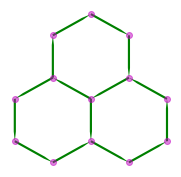

In [ ]:
verts = Vertex(vrn.vertices)
edges = torch.tensor(edge_list)

cell_graph = Monolayer(vertices=Vertex(vrn.vertices.copy()), edges=edges, cells=hex_cells)
# cell_graph.vertices.requires_grad_(True) #<-- use for enabling gradient calculations
print('Perimeter=',cell_graph.perimeter().squeeze(),';\nArea=',cell_graph.area())
# plot monolayer graph
plt.figure(figsize=[3,3])
plot_graph_as_quiver(cell_graph)
plt.plot(cell_graph.vertices.x[:,0],cell_graph.vertices.x[:,1],'mo',alpha=.5);

## Lattice Generator and Helper functions

In [ ]:
#export
def mask2vrn_region(verts,vrn_regions,row_mask):
    '''Apply mask to Voronoi regions and vertices and re-label them.
    
    In addition to the `row_mask` (for vertices), also removes empty regions
    and regions with "-1" Voronoi vertices.
    
    Arg-s:
    - `verts` : Voronoi vertex locations (`numpy` array).
    - `vrn_regions`: Voronoi regions ("cells"). Empty regions and
    out-of-diagram Voronoi regions with "-1" vertices are removed.
    - `row_mask`: 1-d binary mask for `verts` rows.
    
    Returns:
    - `v_x` : vertices after applying the mask (`=verts[row_mask,:]`)
    - `regions`: re-labelled regions (with updated vertex indices) 
    '''
    v_x = verts[row_mask,:]
    idx_0    = np.arange(verts.shape[0])
    idx_keep = idx_0[row_mask]
    idx_new    = np.arange(idx_keep.shape[0])
    # hexagon regions
    regions = [[idx_new[idx_keep==v].item() for v in r] for r in vrn_regions
               if len(r) and (-1 not in r) and np.all(row_mask[r])]
    return v_x, regions

In [ ]:
#export
def unit_hex_seeds(Sx,Sy):
    '''Produces seed locations for Voronoi such that Voronoi regions 
    form rectangle of hexagonal cells with unit side length (==1).
    
    Arg-s:
    - `Sx`, `Sy`: width (x-axis) and height (y-axis) in cells (assumes that both $S_{x,y}>0$)
    
    Returns:
    - `numpy` array with `Sx`x`Sy` rows and 2 columns.
    '''
    # for regular hexagons with unit length edges
    dXY = [np.sqrt(3), 1.5] # original grid spacing
    x_offset = np.sqrt(3)/2 # moves alter-g rows to the right (+ x-axis)
    X,Y = np.meshgrid(np.linspace(0,(Sx-1)*dXY[0],Sx),np.linspace(0,(Sy-1)*dXY[1],Sy))
    X[1::2,:]+=x_offset
    return np.concatenate((X.ravel()[:,np.newaxis],Y.ravel()[:,np.newaxis]),axis=1)

In [ ]:
# export
def unit_hexagons(Ny,Nx):
    '''Produces Ny rows-by-Nx columns of hexagons with unit length edges.
    
    Uses scipy.spatial.Voronoi, and unit_hex_seeds then trims
    non-hexagon edge cells and vertices.
    
    Returns:
    - `v_x`: vertex locations, Mx2 `numpy` array (M number of vertices)
    - `regions`: cell vertices (Voronoi regions; list of lists)
    '''
    def hex_mask_(verts,Nx,l_tol = 0.0001):
        '''Mask for vertices forming closed hexagons'''
        # mask for removing vertices pentagon region tips (left and right sides)
        mask_hex = np.logical_and(verts[:,0]>0, verts[:,0]<(Nx+1.5)*np.sqrt(3))
        v_x = verts[mask_hex,:]
        # remove corner vertices (not forming hexagons)
        Xmin =(1.+l_tol)*v_x.min(axis=0)
        Xmax =(1.-l_tol)*v_x.max(axis=0)
        left_btm = np.logical_not(np.logical_and(verts[:,0]<Xmin[0],verts[:,1]<Xmin[1]))
        left_top = np.logical_not(np.logical_and(verts[:,0]<Xmin[0],verts[:,1]>Xmax[1]))
        rght_top = np.logical_not(np.logical_and(verts[:,0]>Xmax[0],verts[:,1]>Xmax[1]))
        mask_cor = np.logical_and(np.logical_and(left_btm,left_top),rght_top)
        # full mask
        return np.logical_and(mask_hex,mask_cor)
    
    Xseed = unit_hex_seeds(Nx+2,Ny+2)
    vrn = Voronoi(Xseed)
    vrn_mask = hex_mask_(vrn.vertices,Nx)
    v_x,regions = mask2vrn_region(vrn.vertices,vrn.regions,vrn_mask)
    return v_x,regions

**Notes**:
- `unit_hexagons` internally removes non-hexagon region vertices at the boundaries (left and right) produced by `scipy.spatial.Voronoi`
- If you would like to keep these "raw" vertices, you can use `unit_hex_seeds` to seed `scipy.spatial.Voronoi` directly.
---

**Usage examples**:

- Generate graph vertices arranged as a lattice of unit length hexagons

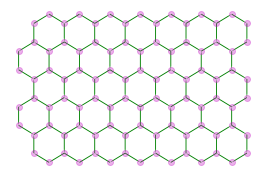

In [ ]:
v_x,regions =unit_hexagons(5,7) # unit hexagon vertices
edge_list,_ = VoronoiRegions2Edges(regions) #get list of edges

# display the graph:
plt.figure(figsize=[4.5,3])
plot_graph_as_quiver(Graph(Vertex(v_x),torch.tensor(edge_list)))
plt.plot(v_x[:,0],v_x[:,1],'mo',alpha=.3)
plt.show()

- Use these vertices and Voronoi regions to generate `Monolayer` objects,
- you can use `VoronoiRegions2Edges` to convert Voronoi regions into an edge list and corresponding cells required for `Monolayer` initialization.

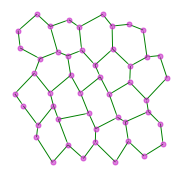

In [ ]:
v_x,regions =unit_hexagons(4,4)

# add some noise
np.random.seed(42) # RNG seed
v_x += np.random.randn(v_x.shape[0], v_x.shape[1])*.2

# get edges and cells (as a set of edges)
edge_list,cells = VoronoiRegions2Edges(regions) 

# create a Monolayer object from the hexagonal cells
cell_graph = Monolayer(vertices=Vertex(v_x.copy()),
                       edges=torch.tensor(edge_list),
                       cells=cells)

figsize=[3,3]
plt.figure(figsize=figsize)
plot_graph_as_quiver(cell_graph)
plt.plot(cell_graph.vertices.x[:,0].detach().cpu(),
         cell_graph.vertices.x[:,1].detach().cpu(),'mo',ms=5,alpha=.5)
plt.show()

In [ ]:
#hide
# run this as a last cell in your notebook to export this module
from nbdev.export import *
notebook2script()

Converted 00_primitives.ipynb.
Converted 01_simulation.ipynb.
Converted index.ipynb.
Converted vertex_dynamics_models.ipynb.
